## Assigment 3

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

### Exercise 1

#### A

- Ix (x,y) = [g(y) * I(x, y)] * dg(x) / dx
- Iy (x, y) = [g(x) * I(x, y)] * dg(y) / dy
- Ixx (x, y) = [g(y) * Ix (x, y)] * dg(x) / dx
- Iyy (x, y) = [g(x) * Iy(x, y)] * dg(y) / dy
- Ixy (x, y) = [g(x) * Ix (x, y)] * dg(y) / dy
- Iyx (x, y) = [g(y) * Iy (x,y)] * dg(x) / dx

#### B

In [26]:
def gaussdx(sigma):
    f = lambda x: np.exp(-x**2/(2*sigma**2)) * (-x/(np.sqrt(2*np.pi) * sigma**3))
    r = np.array(list(map(f, np.arange(-3*sigma, 3*sigma+1))))
    return r / sum(abs(r))

def gaussian(sigma):
    f = lambda x: np.exp(-x**2/(2*sigma**2)) / (np.sqrt(2*np.pi) * sigma)
    r = np.array(list(map(f, np.arange(-3*sigma, 3*sigma+1))))
    return r / sum(r)

In [28]:
g = gaussian(2)
print("Sum:", sum(g))
print("Abs Sum:", sum(abs(g)))
g

Sum: 0.9999999999999999
Abs Sum: 0.9999999999999999


array([0.0022182 , 0.00877313, 0.02702316, 0.06482519, 0.12110939,
       0.17621312, 0.19967563, 0.17621312, 0.12110939, 0.06482519,
       0.02702316, 0.00877313, 0.0022182 ])

In [27]:
gdx = gaussdx(2)
print("Sum:", sum(gdx))
print("Abs Sum:", sum(abs(gdx)))
gdx

Sum: -5.898059818321144e-17
Abs Sum: 1.0


array([ 0.00855153,  0.02818497,  0.06945265,  0.12495619,  0.1556326 ,
        0.11322205,  0.        , -0.11322205, -0.1556326 , -0.12495619,
       -0.06945265, -0.02818497, -0.00855153])

#### C

In [30]:
impulse = np.zeros((50, 50))
impulse[25, 25] = 1

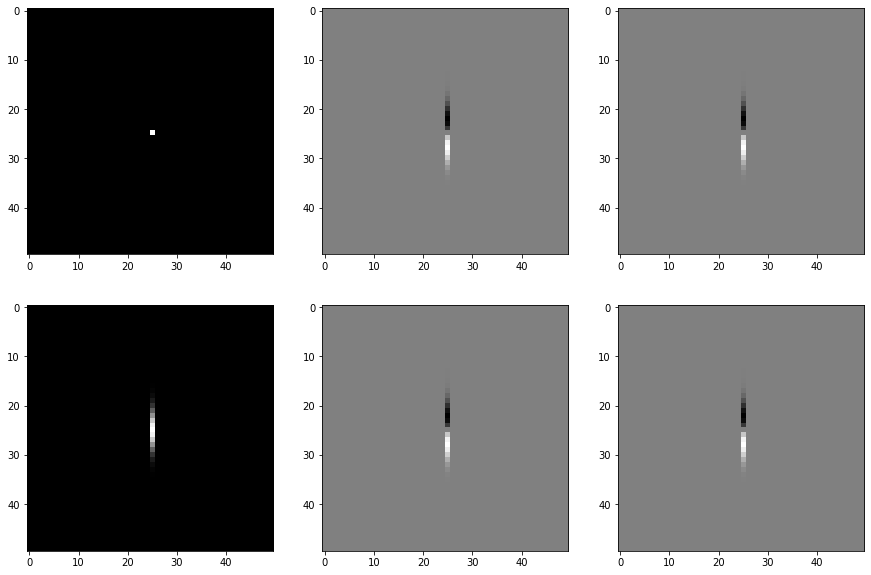

In [39]:
kernels =   [[  (None, None),  (g, gdx.T),      (gdx, g.T)  ],
            [   (g, g.T),      (g.T, gdx),      (gdx.T, g)  ]]

figure, axes = plt.subplots(2, 3, figsize=(15, 10))
for i in range(len(axes)):
    for j in range(len(axes[i])):
        img = impulse.copy()
        if kernels[i][j][0] is not None:
            img = cv2.filter2D(img, -1, kernels[i][j][0])
        if kernels[i][j][1] is not None:
            img = cv2.filter2D(img, -1, kernels[i][j][1])
        axes[i][j].imshow(img, cmap='gray')
